# Torch Batteries Example: Function Fitting with MLP

This notebook demonstrates how to use the `torch-batteries` library to train a Multi-Layer Perceptron (MLP) for function fitting. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps.

## Overview

We'll be fitting a polynomial function: `y = (x-1)(x-6)(x-7)` using a neural network with the Battery trainer class.

## 1. Setup and Dependencies

First, let's import the required libraries and check the versions of torch-batteries and PyTorch.

In [1]:
# Import torch-batteries and other dependencies
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.2.0
PyTorch version: 2.9.1


## 2. Data Preparation

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and split it into training, validation, and test sets.

In [2]:
# Prepare data loaders
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x = np.linspace(0, 10, 300).reshape(-1, 1).astype(np.float32)
y = ((x - 1)*(x - 6)*(x - 7)).astype(np.float32)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

BATCH_SIZE = 16

pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 210
Validation samples: 45
Test samples: 45
Batch size: 16
Training batches: 14
Validation batches: 3
Test batches: 3


## 3. Model Definition and Training

Now we'll define our MLP model using the `@charge` decorator to specify what happens during training, validation, testing, and prediction steps. This event-driven approach makes the code more organized and follows a clear pattern.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

In [3]:
# Import torch-batteries components
import torch.nn as nn
from torch.nn import functional as F
from torch_batteries import Battery, Event, charge

# Define MLP model with charge decorators
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
    @charge(Event.TRAIN_STEP)
    def training_step(self, batch):
        """Define what happens in each training step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        return loss
    
    @charge(Event.VALIDATION_STEP)
    def validation_step(self, batch):
        """Define what happens in each validation step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss
    
    @charge(Event.TEST_STEP)
    def test_step(self, batch):
        """Define what happens in each test step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, batch):
        """Define what happens during prediction."""
        x = batch[0]
        pred = self(x)
        return pred

model = MLPModel(input_dim=1, hidden_dim=64, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(model, optimizer=optimizer)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=100
)

print("Training completed!")
print(f"Final Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {train_results['val_loss'][-1]:.6f}")

Starting training...
Epoch 1/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 872.8733
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 617.6291


Epoch 2/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 700.2134
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 476.7861


Epoch 3/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 491.0160
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 434.4223


Epoch 4/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 446.1514
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 443.7437


Epoch 5/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 450.7795
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 425.4691


Epoch 6/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 435.1940
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 426.8180


Epoch 7/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 433.7234
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 432.6079


Epoch 8/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 441.0258
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 413.9574


Epoch 9/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 428.2875
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 429.8503


Epoch 10/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 437.0341
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 405.9350


Epoch 11/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 413.0957
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 382.7740


Epoch 12/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 405.9751
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 367.9805


Epoch 13/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 392.9095
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 349.9132


Epoch 14/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 382.6929
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 340.0818


Epoch 15/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 377.7304
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 338.9216


Epoch 16/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 403.8084
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 344.3658


Epoch 17/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 373.8253
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 317.6534


Epoch 18/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 372.1711
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 318.8141


Epoch 19/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 358.2308
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 313.7373


Epoch 20/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 352.8582
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 311.1897


Epoch 21/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 347.6589
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 292.7543


Epoch 22/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 333.7744
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 307.5052


Epoch 23/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 324.5491
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 274.9732


Epoch 24/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 359.3443
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 310.9411


Epoch 25/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 299.4079
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 261.8802


Epoch 26/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 304.3376
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 246.9897


Epoch 27/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 312.9301
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 309.6802


Epoch 28/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 280.1038
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 228.0681


Epoch 29/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 268.8020
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 214.4107


Epoch 30/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 253.1649
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 222.4995


Epoch 31/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 222.2469
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 190.4553


Epoch 32/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 210.6528
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 186.4689


Epoch 33/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 193.2075
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 172.4989


Epoch 34/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 199.7563
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 151.5230


Epoch 35/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 168.1737
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 168.1300


Epoch 36/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 183.9105
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 156.8063


Epoch 37/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 156.3767
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 138.4072


Epoch 38/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 132.3693
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 110.0978


Epoch 39/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 117.9041
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 102.9434


Epoch 40/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 102.7063
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 90.5339


Epoch 41/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 98.0758
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 104.9907


Epoch 42/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 177.9945
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 219.5100


Epoch 43/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 168.8835
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 160.4123


Epoch 44/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 142.2431
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 111.5986


Epoch 45/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 137.2661
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 79.7719


Epoch 46/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 104.7879
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 89.9890


Epoch 47/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 92.2888
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 65.0851


Epoch 48/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 74.4207
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 63.2043


Epoch 49/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 71.3503
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 76.8279


Epoch 50/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 74.0920
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 55.3211


Epoch 51/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 66.2278
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 53.0184


Epoch 52/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 63.0914
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 45.4303


Epoch 53/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 49.2029
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 49.4556


Epoch 54/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 46.7324
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 39.9435


Epoch 55/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 42.1226
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 39.4811


Epoch 56/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 41.2996
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.8187


Epoch 57/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 36.5800
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 32.6790


Epoch 58/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 59.0087
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 59.3799


Epoch 59/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 46.1661
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 37.9195


Epoch 60/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 47.2875
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 66.2512


Epoch 61/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 50.3878
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 32.9985


Epoch 62/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 60.7972
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 31.2528


Epoch 63/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 38.8179
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 23.4746


Epoch 64/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 30.7112
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 23.8043


Epoch 65/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.1107
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 22.6689


Epoch 66/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.1383
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 23.7648


Epoch 67/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 25.0429
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 22.1538


Epoch 68/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 21.8891
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.4718


Epoch 69/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 22.0246
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 19.5729


Epoch 70/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 19.2145
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.8623


Epoch 71/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 17.7510
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 13.8740


Epoch 72/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.9477
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 12.6224


Epoch 73/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.9021
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 21.1498


Epoch 74/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 27.3031
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.0185


Epoch 75/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 16.8779
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.4746


Epoch 76/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 14.9803
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 13.1358


Epoch 77/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 13.5096
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.8380


Epoch 78/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.9788
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 10.0325


Epoch 79/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.9480
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 14.1467


Epoch 80/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.0774
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.3690


Epoch 81/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.7212
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 6.4152


Epoch 82/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 11.9138
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.4249


Epoch 83/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.2240
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.6491


Epoch 84/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.3638
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.5137


Epoch 85/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.4458
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.1373


Epoch 86/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.4533
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.3969


Epoch 87/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.0989
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.6272


Epoch 88/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.1098
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 4.2479


Epoch 89/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 6.8824
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.6650


Epoch 90/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 9.2737
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 12.0241


Epoch 91/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.0303
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 3.8022


Epoch 92/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 5.7022
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 4.9450


Epoch 93/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 6.0672
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 6.6751


Epoch 94/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.3672
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 7.9132


Epoch 95/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.3907
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.4242


Epoch 96/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.1276
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.2365


Epoch 97/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.4856
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 4.9340


Epoch 98/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 11.8943
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.0118


Epoch 99/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.7577
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 5.9043


Epoch 100/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 5.5270
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 3.6818

Training completed!
Final Training Loss: 5.527032
Final Validation Loss: 3.681779


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [4]:
test_results = battery.test(test_loader)
print(f"Final Test Loss: {test_results['test_loss']:.6f}")

Test: 3/3 ███████████████████████████████████████████████████ 100%, loss: 4.7909

Final Test Loss: 4.790867


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to approximate the target function.

Predict: 19/19 ████████████████████████████████████████████████████████████ 100%


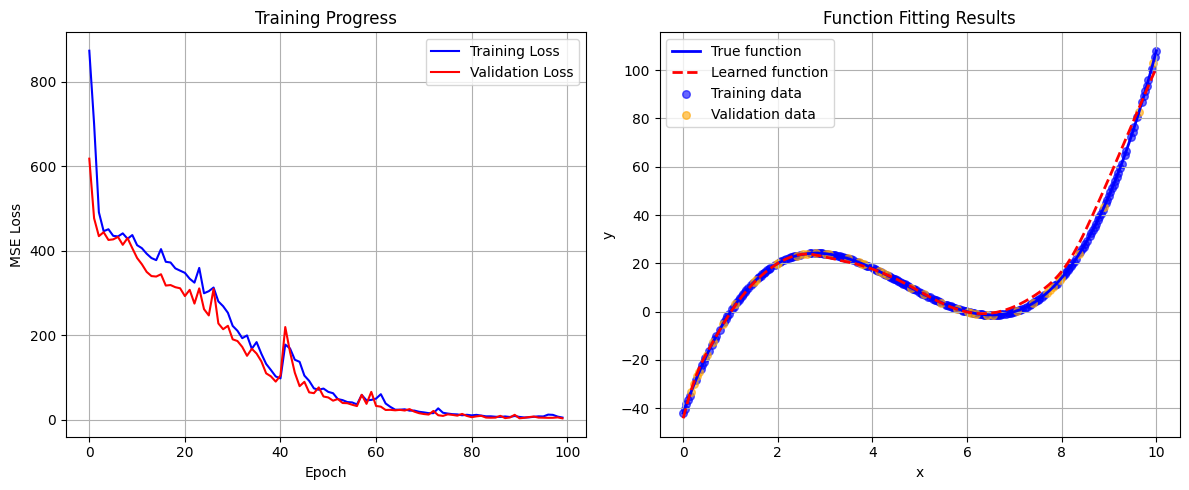

In [5]:
import matplotlib.pyplot as plt

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results['train_loss'], 'b-', label='Training Loss')
plt.plot(train_results['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

predictions = battery.predict(pred_full_loader)['predictions']

# Concatenate predictions
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

# Plot actual vs predicted function
plt.subplot(1, 2, 2)
plt.plot(x_np, y, 'b-', label='True function', linewidth=2)
plt.plot(x_np, y_pred, 'r--', label='Learned function', linewidth=2)
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, c='blue', label='Training data')
plt.scatter(x_val.numpy(), y_val.numpy(), alpha=0.6, s=30, c='orange', label='Validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Fitting Results')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()